<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...


--2022-12-17 13:46:40--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  329K 5m23s
    50K .......... .......... .......... .......... ..........  0%  659K 4m2s
   100K .......... .......... .......... .......... ..........  0% 46.6M 2m42s
   150K .......... .......... .......... .......... ..........  0% 32.1M 2m2s
   200K .......... .......... .......... .......... ..........  0%  667K 2m9s
   250K .......... .......... .......... .......... ..........  0% 37.8M 1m48s
   300K .......... .......... .......... .......... ..........  0% 35.2M 93s
   350K .......... .......... .......... .......... ..........  0%  180M 82s
   400K .......... 

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2022-12-17 13:46:48--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2022-12-17 13:46:48--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  408K 36s
    50K .......... .......... .......... .......... ..........  0%  826K 26s
   100K .......... .......... .......... .......... ..........  1%  881K 23s
   150K .......... .......... ..........

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, attrs, random_state=42)

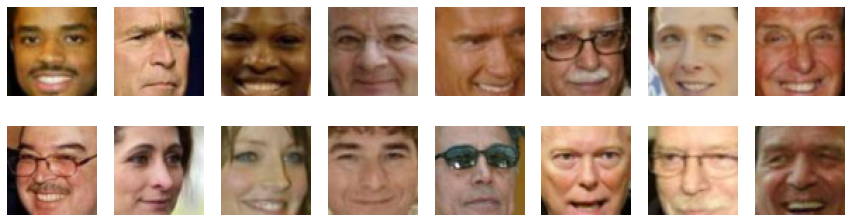

In [12]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 32


train_loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=BATCH_SIZE)
test_loader = DataLoader(np.rollaxis(X_test, 3, 1), batch_size=BATCH_SIZE)

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(X_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_train[random_index])
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [13]:
dim_code = 128 # выберите размер латентного вектора
input_shape = X_train.shape[1:]
input_shape

(64, 64, 3)

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.encoder_fc = nn.Linear(64 * 64 * 64, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 64 * 64 * 64) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
        )

    def encode(self, x):
      latent_code = self.encoder_fc(self.encoder_flatten(self.encoder(x)))
      return latent_code
    
    def decode(self, x):
      reconstruction = self.decoder_fc(x)
      reconstruction = reconstruction.view(-1, 64, 64, 64)
      reconstruction = self.decoder(reconstruction)
      reconstruction = torch.sigmoid(reconstruction)
      return reconstruction
        
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        
        return reconstruction, latent_code

In [30]:
criterion = torch.nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder(dim_code).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [29]:
from tqdm.auto import tqdm
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, path='', device=device):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_batch in train_loader:
            X_batch = X_batch.float()
            X_batch = X_batch.to(device)
            reconstruction, _ = model(X_batch)
            loss = criterion(reconstruction, X_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X_batch in val_loader:
                X_batch = X_batch.to(device,dtype=torch.float)
                reconstruction, _ = model(X_batch)

                loss = criterion(reconstruction, X_batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))
        scheduler.step()

        if epoch % 5 == 0:
            print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}", f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')
        
        del X_batch
        del reconstruction
        del loss
        torch.cuda.empty_cache()
    return model, train_loss_epoch, val_loss_epoch

In [41]:
def predict(model, val_loader):
    reconstructions, latent_outputs = [], []
    model.eval()
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device).float()
            reconstructed, latent_output = model(X_batch)
            reconstructions.append(reconstructed.cpu())
            latent_outputs.append(latent_output.cpu())
    
    return torch.cat(reconstructions), torch.cat(latent_outputs)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [32]:
model, train_loss, val_loss = train(autoencoder, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100, path='autoencoder', device=device)
torch.save(model.state_dict(), 'autoencoder/auto_model_final.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.017850 val loss: 0.009145
After 5 epochs, training loss: 0.007651 val loss: 0.008342
After 10 epochs, training loss: 0.005945 val loss: 0.006569
After 15 epochs, training loss: 0.005127 val loss: 0.005568
After 20 epochs, training loss: 0.004636 val loss: 0.004996
After 25 epochs, training loss: 0.004302 val loss: 0.004605
After 30 epochs, training loss: 0.004058 val loss: 0.004323
After 35 epochs, training loss: 0.003869 val loss: 0.004106
After 40 epochs, training loss: 0.003722 val loss: 0.003930
After 45 epochs, training loss: 0.003600 val loss: 0.003788
After 50 epochs, training loss: 0.003499 val loss: 0.003669
After 55 epochs, training loss: 0.003413 val loss: 0.003569
After 60 epochs, training loss: 0.003339 val loss: 0.003484
After 65 epochs, training loss: 0.003276 val loss: 0.003411
After 70 epochs, training loss: 0.003220 val loss: 0.003347
After 75 epochs, training loss: 0.003171 val loss: 0.003292
After 80 epochs, training loss: 0.003127 v

In [ ]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot(train_loss, val_loss)

In [26]:
def swap_dims(img):
    if img.shape[0] == 3:
        return np.rollaxis(img, 0, 3)
    elif img.shape[0] == 1:
        return img[0]
    return img
def plot_images(n_rows, n_cols, first_line, first_title=None, second_line=[], second_title=None, third_line=[], third_title=None, plt_title=None):
    plt.figure(figsize=(20, 10))
    if len(third_line) != 0:
        for i in range(n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)

            plt.subplot(n_rows, n_cols, i + n_cols + 1)
            plt.imshow(swap_dims(second_line[i]))
            if second_title is not None:
                plt.title(second_title)
            plt.axis('off')

            plt.subplot(n_rows, n_cols, i + 2 * n_cols + 1)
            plt.imshow(swap_dims(third_line[i]))
            if third_title is not None:
                plt.title(third_title)
            plt.axis('off')
    if len(second_line) != 0:
        for i in range(n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)

            plt.subplot(n_rows, n_cols, i + n_cols + 1)
            plt.imshow(swap_dims(second_line[i]))
            if second_title is not None:
                plt.title(second_title)
            plt.axis('off')
    else:
        for i in range(n_rows * n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)
            plt.axis('off')
    if plt_title:
        plt.suptitle(plt_title)
    plt.show()

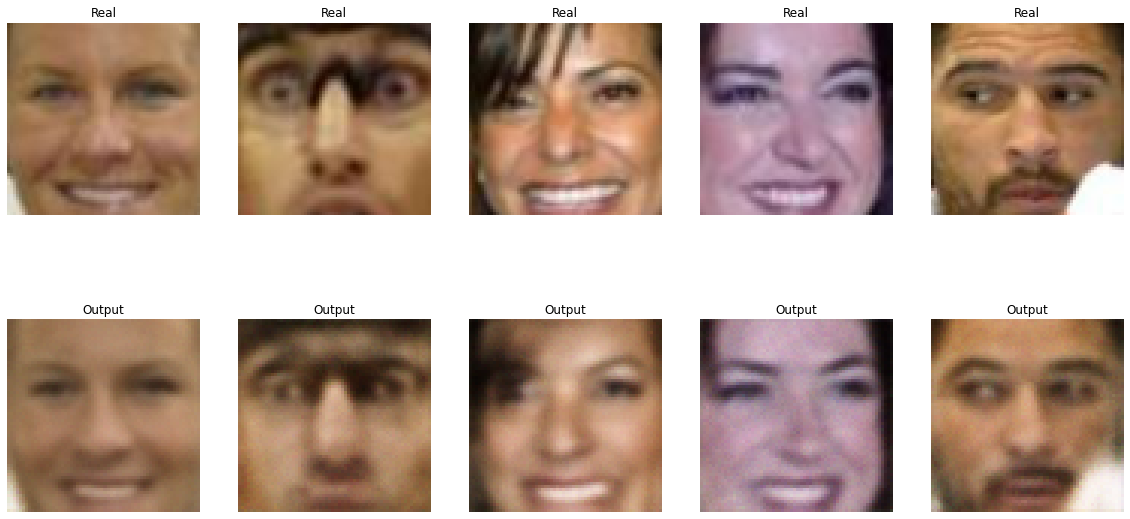

In [44]:
reconstructions, latent_outputs = predict(autoencoder, test_loader)
ground_truth = next(iter(test_loader))
plot_images(2, 5, ground_truth[:5].numpy(), "Real", reconstructions[:5].numpy(), "Output")

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [45]:
def plot_reconstruction(y_pred):
  plt.figure(figsize=(15, 15))
  for i, output0 in enumerate(y_pred):
    plt.subplot(5, 5 , i+1)
    plt.imshow(output0.reshape(input_shape).clip(0,1))

plt.show()

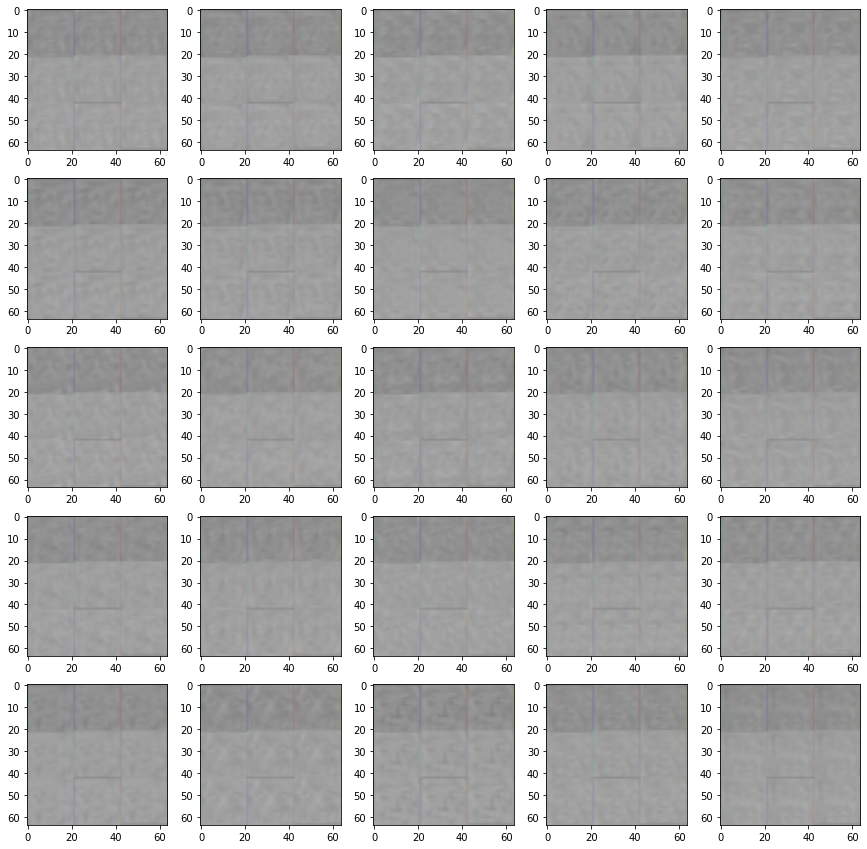

In [46]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
z = torch.tensor(z, dtype=torch.float32).to(device)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z).cpu()
plot_reconstruction(output)

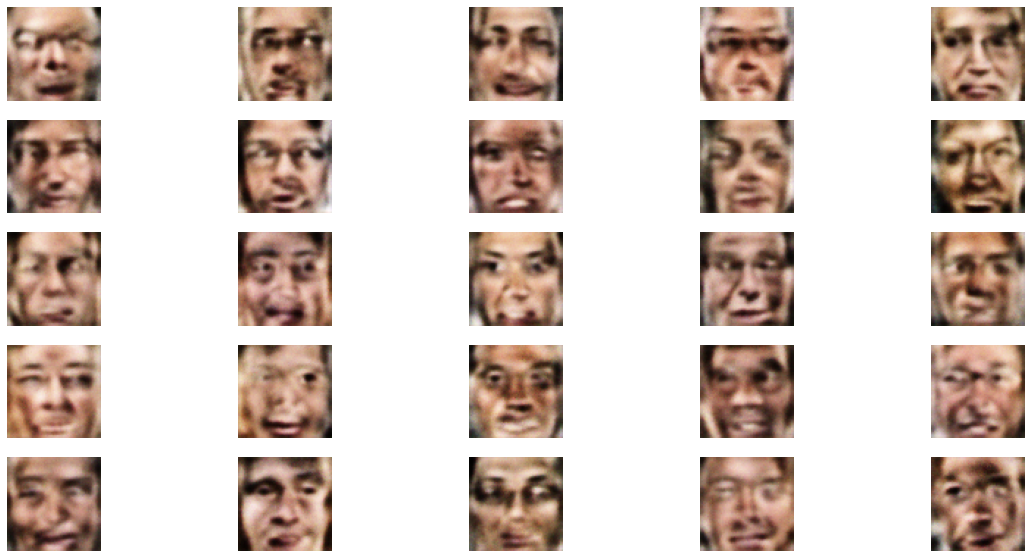

In [50]:
mu = torch.mean(latent_outputs, 0)
sigma = torch.std(latent_outputs, 0)
z = torch.cat([(mu + (torch.randn_like(sigma) * sigma)).view(1, -1) for _ in range(25)]).to(device)
autoencoder.eval()
with torch.no_grad():
    random_samples = autoencoder.decode(z).cpu()
plot_images(5, 5, random_samples.numpy())

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [86]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,-0.205363,-0.202842,-1.232735,-1.409125,-1.804858,0.287268,-0.521815,-0.789165,-1.008119,0.531813,...,-0.867156,-0.879554,-0.179497,0.323676,-2.188852,-1.169369,0.924397,-0.217415,-0.414024,-0.495178
13139,1.957472,-2.47247,-1.307994,-0.671636,-1.960125,-0.838803,-1.365955,0.510448,-1.262193,0.418947,...,-2.487289,2.608861,-0.95419,-1.599463,-1.23822,-1.187034,1.87413,-0.832614,0.152785,-0.554331
13140,-0.037001,-1.16415,0.228494,0.187503,-1.836475,-0.958412,-0.669697,-0.48033,0.493433,-1.893151,...,-1.938639,-0.49108,0.495067,-0.524767,-1.073731,0.11101,0.976262,-0.453027,-0.399981,-1.078655
13141,0.282219,-0.396198,1.27047,-1.981209,-1.70294,-1.507203,-2.330721,-0.295928,1.056618,-1.613698,...,-0.662101,-1.692131,1.284772,-0.80818,-0.710051,0.694621,0.936065,-0.7675,1.14693,-0.26094


In [52]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [54]:
smiling_faces_idxs = attrs['Smiling'].sort_values(ascending=False).head(15).index.values
smiling_faces_data = data[smiling_faces_idxs]

no_smiling_idxs = attrs['Smiling'].sort_values(ascending=False).tail(15).index.values
no_smiling_data = data[no_smiling_idxs]

In [60]:
smiling_faces_data.shape

(15, 64, 64, 3)

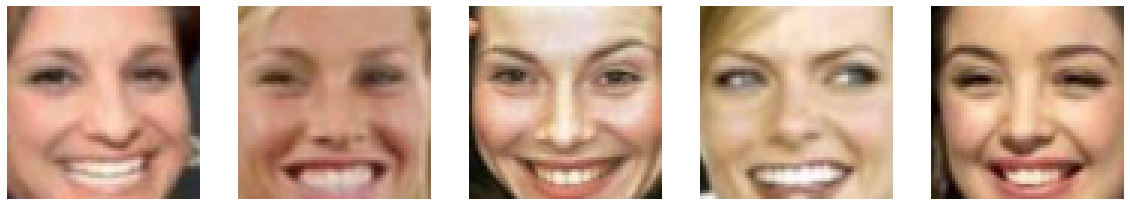

In [66]:
plot_images(1, 5, smiling_faces_data[:5])

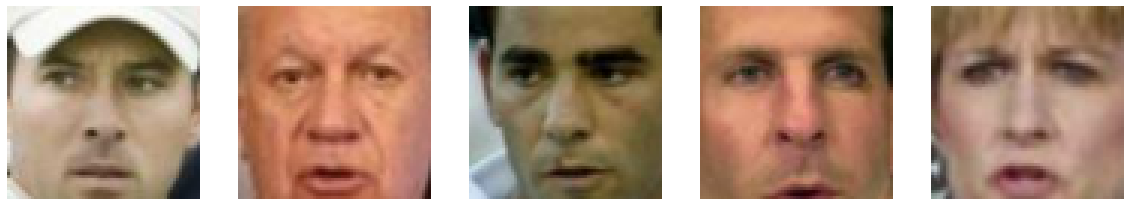

In [67]:
plot_images(1, 5, no_smiling_data[:5])

In [73]:
def get_latent_vectors(autoencoder, image_data):
    with torch.no_grad():
        image_tensor = torch.tensor(np.rollaxis(image_data, 3, 1), dtype=torch.float32)
        image_tensor = image_tensor.to(device)
        autoencoder.eval()
        latent_vectors = autoencoder.encode(image_tensor).cpu()
        return latent_vectors

def reconstruct_images(autoencoder, latent_vectors):
    with torch.no_grad():
        latent_vectors = latent_vectors.to(device)
        autoencoder.eval()
        reconstruction = autoencoder.decode(latent_vectors).cpu()
        return reconstruction

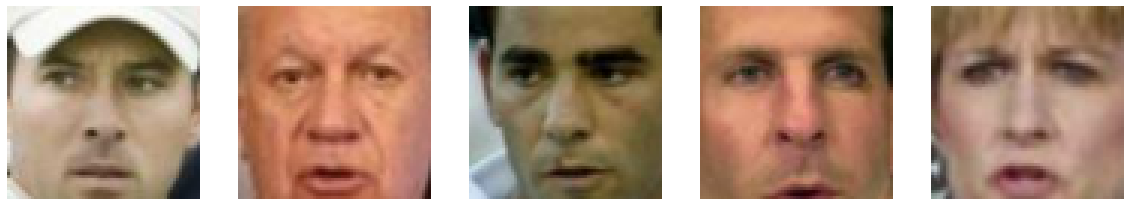

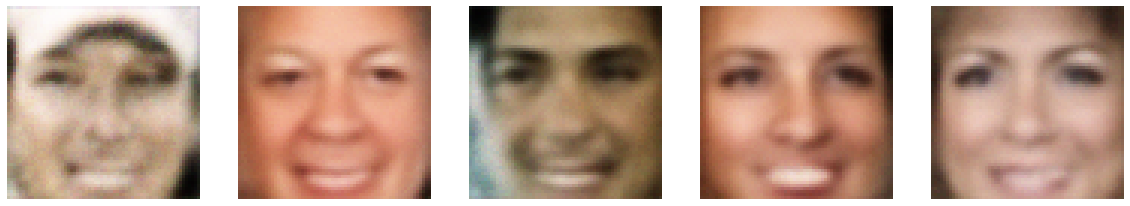

In [75]:
smiling_latent_vectors = get_latent_vectors(autoencoder, smiling_faces_data)
smiling_vector = smiling_latent_vectors.mean(axis=0)

no_smiling_latent_vectors = get_latent_vectors(autoencoder, no_smiling_data)
no_smiling_vector = no_smiling_latent_vectors.mean(axis=0)

smile_vector = smiling_vector - no_smiling_vector
updated_no_smiling_vectors = no_smiling_latent_vectors + smile_vector
updated_no_smiling_images = reconstruct_images(autoencoder, updated_no_smiling_vectors)
plot_images(1, 5, no_smiling_data[:5])
plot_images(1, 5, updated_no_smiling_images[:5].numpy())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
from torchvision import transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [34]:
class VAE(nn.Module):
    def __init__(self, inp, latent_dim, num_channels):
        '''
        определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        '''
        super().__init__()
        self.inp = inp
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.mu_fc = nn.Linear(32 * inp * inp, latent_dim)
        self.logsigma_fc = nn.Linear(32 * inp * inp, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 32 * inp * inp)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_channels, kernel_size=3, padding=1),
        )
        

    def encode(self, x):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        '''
        encoded = self.encoder(x)
        flattened = self.encoder_flatten(encoded)
        mu = self.mu_fc(flattened)
        logsigma = self.logsigma_fc(flattened)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            '''
            return mu + (torch.exp(logsigma) * torch.randn_like(logsigma))
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        '''
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        '''
        reconstruction = self.decoder_fc(z)
        reconstruction = reconstruction.view(-1, 32, self.inp, self.inp)
        reconstruction = self.decoder(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu, logsigma = self.encode(x)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma))
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [15]:
dim_code = 128

In [3]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction="sum")
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [73]:
criterion = loss_vae
image_dim = 28
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = VAE(image_dim, dim_code, 1).to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [39]:
from tqdm.auto import tqdm
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, path='', device=device):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_batch, _ in train_loader:
            X_batch = X_batch.float()
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device,dtype=torch.float)
                mu, logsigma, reconstruction = model(X_batch)

                loss = criterion(X_batch, mu, logsigma, reconstruction)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))
        scheduler.step()

     
        print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}", f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')
        
        del X_batch
        del reconstruction
        del loss
        del mu
        del logsigma
        torch.cuda.empty_cache()
    return model, train_loss_epoch, val_loss_epoch

In [74]:
model, train_loss, val_loss = train(autoencoder, train_loader, test_loader, criterion, optimizer, scheduler, epochs=10, path='vae', device=device)
torch.save(model.state_dict(), 'vae/vae_model_final.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

After 0 epochs, training loss: 4806.801758 val loss: 3332.147705
After 1 epochs, training loss: 4166.376465 val loss: 3197.808594
After 2 epochs, training loss: 3864.745361 val loss: 3090.949951
After 3 epochs, training loss: 3685.865479 val loss: 3022.802246
After 4 epochs, training loss: 3564.991455 val loss: 2969.244629
After 5 epochs, training loss: 3476.469971 val loss: 2926.207764
After 6 epochs, training loss: 3407.840332 val loss: 2891.778076
After 7 epochs, training loss: 3352.634033 val loss: 2862.013672
After 8 epochs, training loss: 3307.000977 val loss: 2838.080811
After 9 epochs, training loss: 3268.453613 val loss: 2816.731201


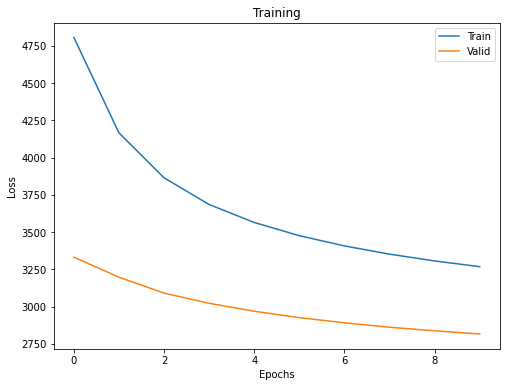

In [75]:
plot(train_loss, val_loss)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [76]:
def predict_vae(model, test_loader):
    reconstructions, mus, logsigmas = [], [], []
    model.eval()
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            mu, logsigma, reconstructed = model(X_batch)
            reconstructions.append(reconstructed.cpu())
            mus.append(mu.cpu())
            logsigmas.append(logsigma.cpu())
    
    return torch.cat(reconstructions), torch.cat(mus), torch.cat(logsigmas)

In [77]:
reconstructions, mus, logsigmas = predict_vae(model, test_loader)
ground_truth = next(iter(test_loader))[0]

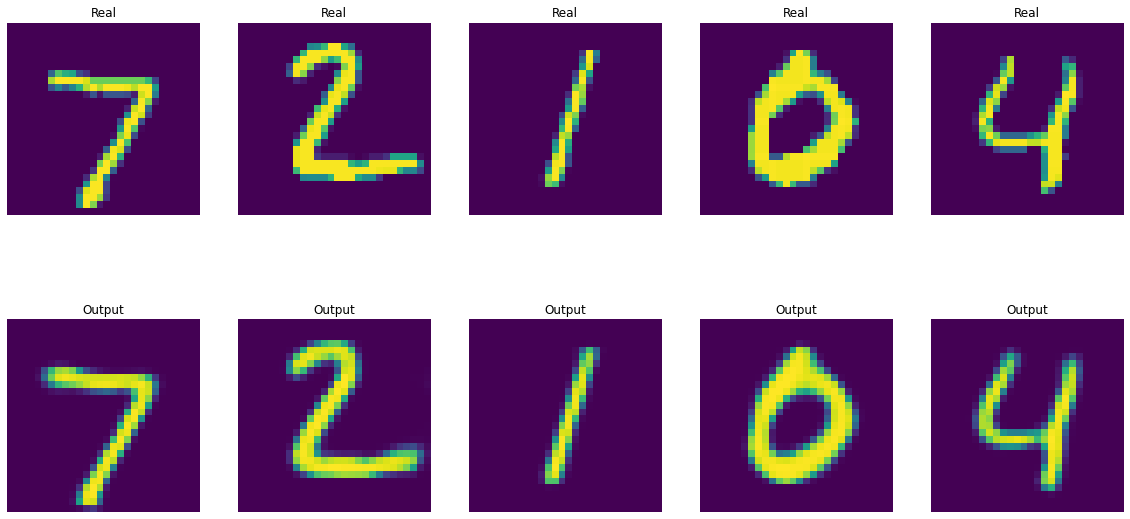

In [78]:
plot_images(2, 5, ground_truth[:5].numpy(), "Real", reconstructions[:5].numpy(), "Output")

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

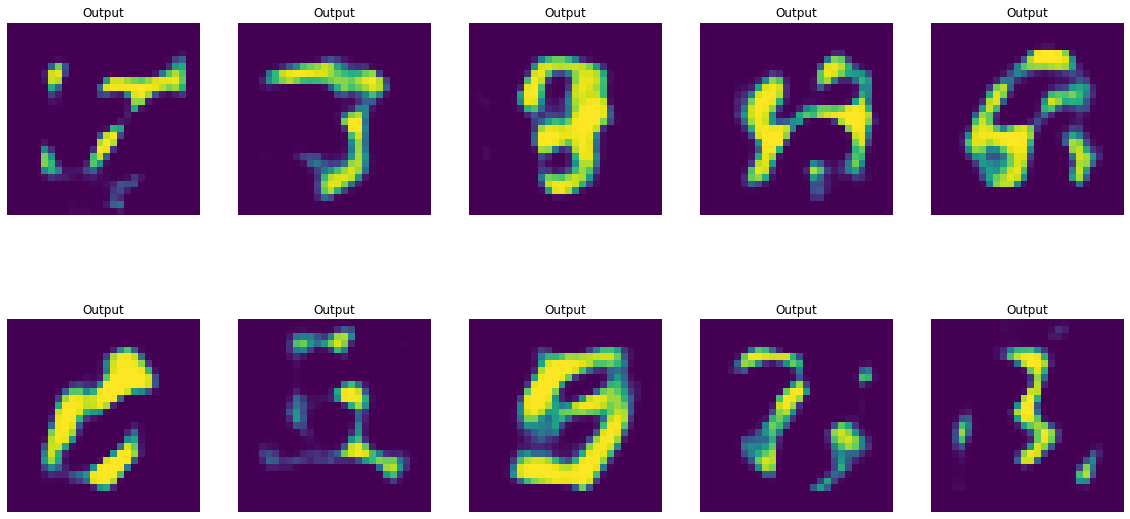

In [79]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
z = torch.tensor(z, dtype=torch.float32).to(device)
output = model.decode(z)
plot_images(2, 5, output[:10].cpu().detach().numpy(), "Output")

ОСОБО много не надо эпох, потому что всё восстанавливается с 15 почти идеально, поэтому можно и 10, а рандомные картинки и так не очень. Если брать 50 эпох, то лосс начинает медленно падать очень медленно падать с 10-15 лосса 

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


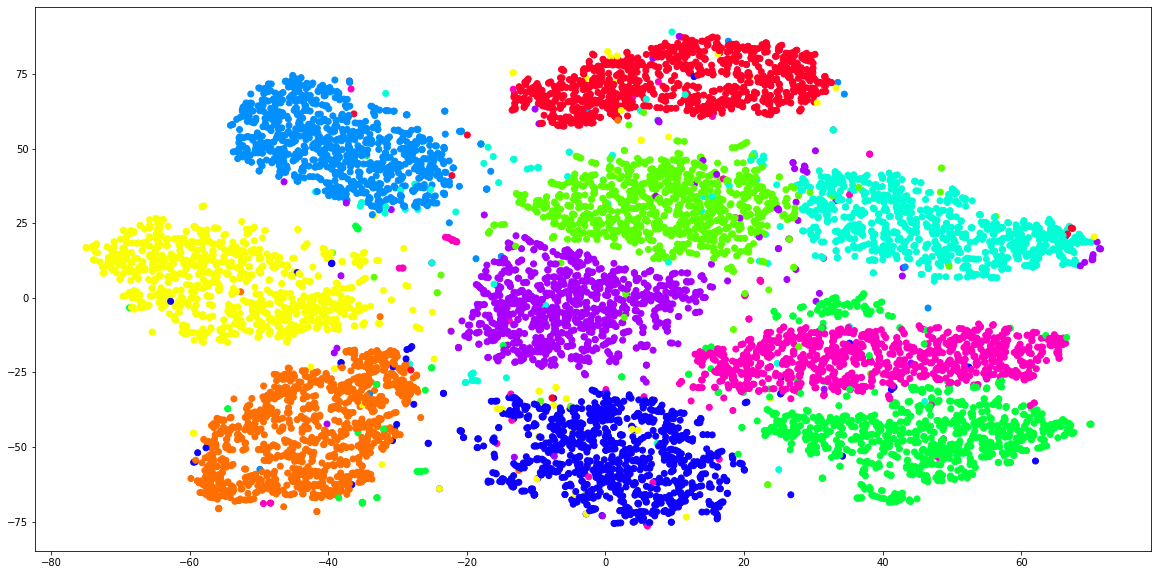

In [81]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>

from sklearn.manifold import TSNE
mus_reduced = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))
plt.figure(figsize=(20, 10))
plt.scatter(mus_reduced[:, 0], mus_reduced[:, 1], c=test_dataset.targets, cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [10]:
def compute_size_after_conv(x, kernel, stride=1, padding=0):
    return int((x - kernel + 2 * padding) / stride + 1)
class CVAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, n_classes: int):
      super().__init__()
      self.latent_dim = latent_dim
      self.n_classes = n_classes
      before_linear_dim = compute_size_after_conv(compute_size_after_conv(input_dim, 3), 3)
      self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(before_linear_dim**2 * 128, self.latent_dim * 2)         
      )
      self.decoder = nn.Sequential(
        nn.Linear(self.latent_dim + self.n_classes, before_linear_dim**2 * 128),
        nn.ReLU(),
        nn.Unflatten(1, (128, before_linear_dim, before_linear_dim)),
        nn.ConvTranspose2d(128, 64, 3),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, 3),
        nn.Sigmoid()
      )

    def encode(self, x, class_num):
      mu, logsigma = torch.split(self.encoder(x), self.latent_dim, dim=1)
      return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
        return mu + torch.exp(logsigma) * torch.normal(mean=0, std=torch.ones(mu.shape)).to(device)
      else:
        # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
        # на инференсе выход автоэнкодера должен быть детерминирован.
        return mu
    
    def decode(self, z, class_num):
      concated_vector = torch.concat((z, class_num), dim=1)
      reconstruction = self.decoder(concated_vector)
      return reconstruction

    def forward(self, x, class_num):
      mu, logsigma, class_num = self.encode(x, class_num)
      reconstruction = self.decode(self.gaussian_sampler(mu, logsigma), class_num)
      return reconstruction, mu, logsigma

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from tqdm.auto import tqdm
def train_cvae(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, path='', device=device):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.float()
            X_batch = X_batch.to(device)
            Y_batch = torch.nn.functional.one_hot(Y_batch, model.n_classes).to(device)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(X_batch, Y_batch)
            loss = criterion(X_batch, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device,dtype=torch.float)
                Y_batch = torch.nn.functional.one_hot(Y_batch, model.n_classes).to(device)
                reconstruction, mu, logsigma = model(X_batch, Y_batch)

                loss = criterion(X_batch, mu, logsigma, reconstruction)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))
        scheduler.step()

     
        print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}", f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')
        
        del X_batch
        del reconstruction
        del loss
        del mu
        del logsigma
        del Y_batch
        torch.cuda.empty_cache()
    return model, train_loss_epoch, val_loss_epoch

In [16]:
def predict_cvae(model, val_loader):
    reconstructions, mus, logsigmas = [], [], []
    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = torch.nn.functional.one_hot(Y_batch, model.n_classes).to(device)
            reconstructed, mu, logsigma = model(X_batch, Y_batch)
            reconstructions.append(reconstructed.cpu())
            mus.append(mu.cpu())
            logsigmas.append(logsigma.cpu())
    
    return torch.cat(reconstructions), torch.cat(mus), torch.cat(logsigmas)

In [20]:
n_classes = 10
image_dim = 28
latent_dim = 24
criterion = loss_vae
cvae = CVAE(image_dim, latent_dim, n_classes).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
model, train_loss, val_loss = train_cvae(cvae, train_loader, test_loader, criterion, optimizer, scheduler, 15, path='cae')
torch.save(cvae.state_dict(), 'cvae/cvae_model_final.pt')

  0%|          | 0/15 [00:00<?, ?it/s]

After 0 epochs, training loss: 3899.850342 val loss: 2953.066406
After 1 epochs, training loss: 3464.555176 val loss: 2863.099854
After 2 epochs, training loss: 3280.142822 val loss: 2813.500732
After 3 epochs, training loss: 3173.520264 val loss: 2778.634521
After 4 epochs, training loss: 3102.040771 val loss: 2750.326416
After 5 epochs, training loss: 3049.784912 val loss: 2728.515381
After 6 epochs, training loss: 3009.546875 val loss: 2714.056152
After 7 epochs, training loss: 2977.165771 val loss: 2699.402344
After 8 epochs, training loss: 2950.370850 val loss: 2685.140137
After 9 epochs, training loss: 2927.768066 val loss: 2675.943359
After 10 epochs, training loss: 2908.230225 val loss: 2664.526855
After 11 epochs, training loss: 2891.162598 val loss: 2656.305664
After 12 epochs, training loss: 2876.026367 val loss: 2649.279785
After 13 epochs, training loss: 2862.437256 val loss: 2642.765381
After 14 epochs, training loss: 2850.173828 val loss: 2637.993652


FileNotFoundError: [Errno 2] No such file or directory: 'cvae/cvae_model_final.pt'

In [21]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

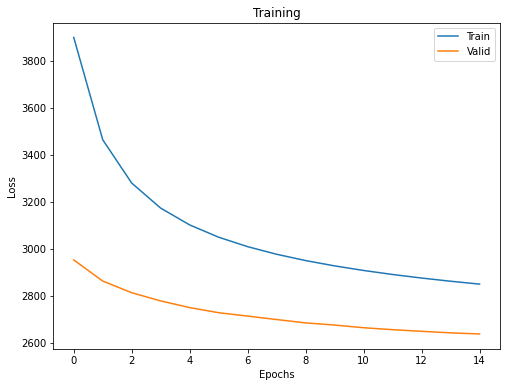

In [23]:
plot(train_loss, val_loss)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

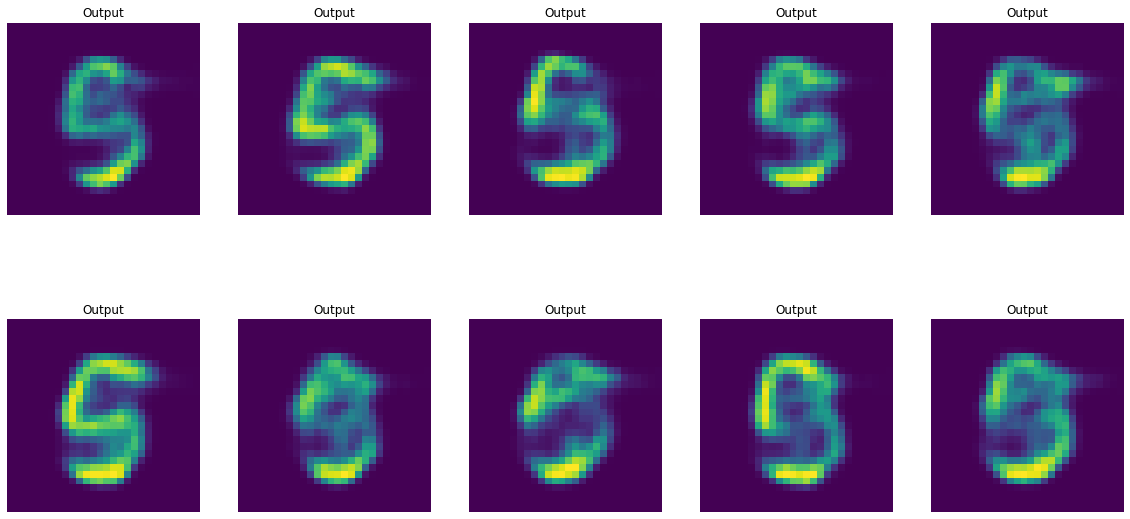

In [33]:
X_batch, y_batch = next(iter(test_loader))
X_batch = X_batch.to(device)
y_batch = torch.nn.functional.one_hot(y_batch, model.n_classes).to(device)
X_batch_recon = model.gaussian_sampler(*model.encode(X_batch, y_batch)[:-1])
batch_means = X_batch_recon.mean(axis=0).cpu().detach().numpy() # for stable generation

RANDOM_FACTOR = 10
random_part = np.random.normal(0, 1, (100, latent_dim)) / RANDOM_FACTOR

z = torch.FloatTensor(batch_means + random_part).to(device)
class_num = torch.nn.functional.one_hot(torch.LongTensor(np.array([5] * 50 + [7] * 50)), model.n_classes).to(device)
reconstruction = model.decode(z, class_num)
reconstruction = torch.squeeze(reconstruction, 1)
plot_images(2, 5, reconstruction[:10].cpu().detach().numpy(), "Output")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [28]:
reconstructions, mus, logsigmas = predict_cvae(model, test_loader)
ground_truth = next(iter(test_loader))[0]

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


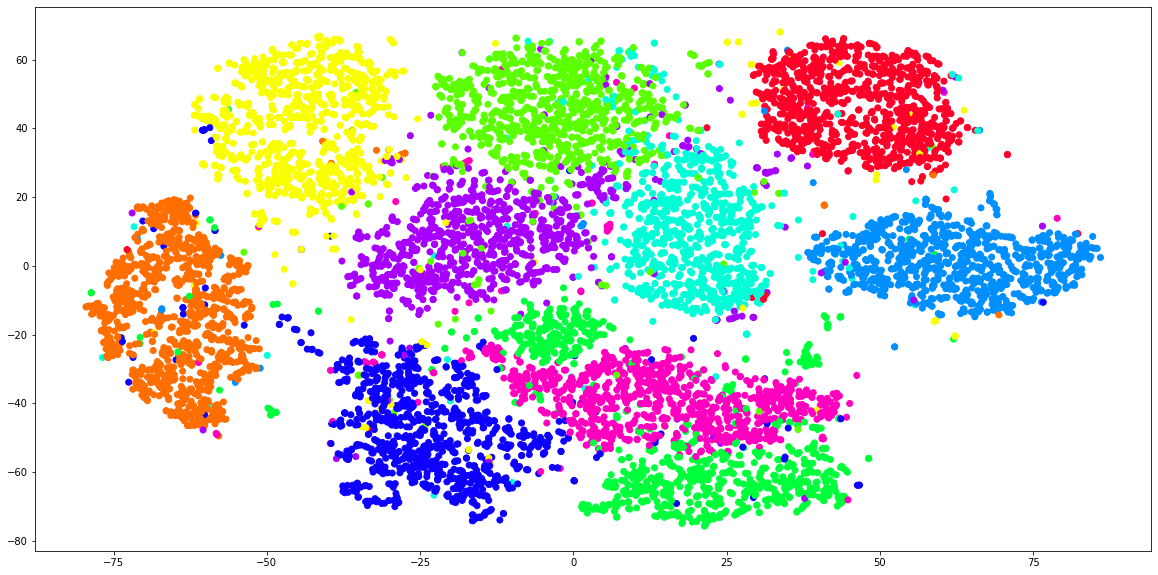

In [29]:
from sklearn.manifold import TSNE
mus_reduced = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))
plt.figure(figsize=(20, 10))
plt.scatter(mus_reduced[:, 0], mus_reduced[:, 1], c=test_dataset.targets, cmap='gist_rainbow')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>